In [1]:
import tensorflow as tf
import math
import numpy as np
tf.enable_eager_execution()
print(tf.__version__)

C:\Users\dakuang.shen\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.14.0


In [2]:
## utils中的method
def get_shape_list(input_tensor):

    return input_tensor.shape.as_list()
    
def to_multi_head(input_tensor, batch_size, num_attention_heads, seq_length, width):
    input_tensor = tf.reshape(input_tensor, [batch_size, seq_length, num_attention_heads, width])
    output_tensor = tf.transpose(input_tensor, [0, 2, 1, 3])
    return output_tensor

def gelu(x):
    cdf = 0.5 * (1.0 + tf.tanh(
        (np.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3)))))
    return x * cdf

def create_initializer(initializer_range=0.02):
  """Creates a `truncated_normal_initializer` with the given range."""
  return tf.truncated_normal_initializer(stddev=initializer_range)

# 本文档记录了bert official 代码中transformer_model 模块，文档帮助评测Pavo下BERT序列长度为384的Finetune的性能。  
bert的主体结构来自于transformer[Attention is all your need](https://arxiv.org/pdf/1706.03762.pdf)  
该部分主要介绍transformer中的Multi-Head Attention 与Feed Forward Network 两个核心模块
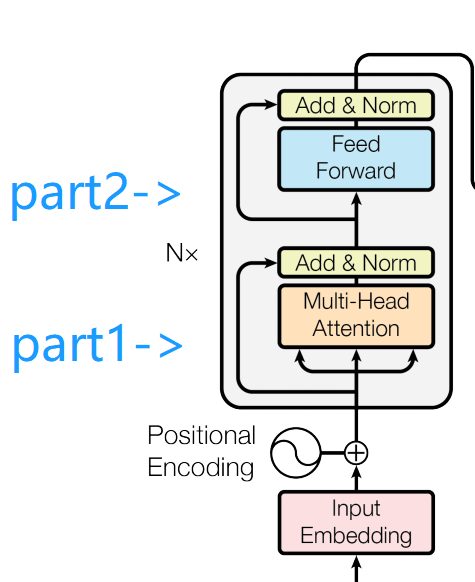

#### bert large config 参数：

In [3]:
bert_config = {
  "attention_probs_dropout_prob": 0.1, 
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "type_vocab_size": 2,
  "vocab_size": 30522
}

假设，  
batch_size=12  
max_sequence_length = 384  
创造transformer_model的输入数据:  
1.embedding_output：模型的输入数据[12, 384, 1024]  
2.attention_mask: 根据input_mask转换的数据(区别pad)，已由2D转成3D[12, 384, 384]  

In [4]:
batch_size=12  
max_sequence_length = 384

In [5]:
## 模型的输入数据： token_embeddings +  segment_embeddings + position_embeddings
input_tensor = tf.random.uniform((batch_size, max_sequence_length, bert_config["hidden_size"]), -1, 1)
get_shape_list(input_tensor)

[12, 384, 1024]

In [6]:
## 模型的mask数据：本来是input_mask [12, 384] 经过broadcast 转为[12, 384, 384]
attention_mask = tf.random.uniform((batch_size, max_sequence_length, max_sequence_length), -1, 1)
get_shape_list(attention_mask)

[12, 384, 384]

In [7]:
hidden_size = bert_config["hidden_size"]
num_attention_heads = bert_config["num_attention_heads"] # 16
attention_head_size = hidden_size //num_attention_heads #64
input_shape = get_shape_list(input_tensor) #[12, 384, 1024]
batch_size = input_shape[0] # 12
seq_length = input_shape[1] # 384
input_width = input_shape[2] #1024

输入数据与模型的配置参数都已到位，我们先来介绍一下第一部分：Multi-Head Attention 模块  
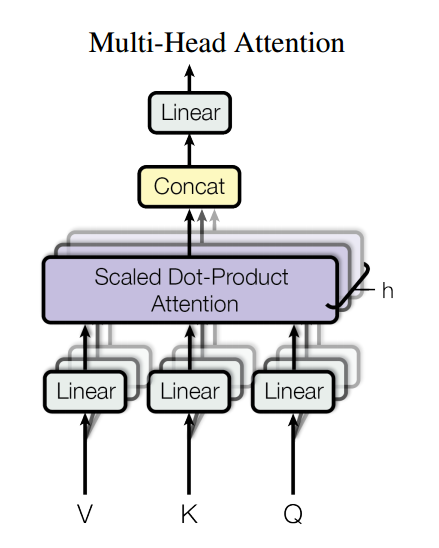  

你可以理解为假设模型的输入为input_tensor[12\*384, 1024]，先使用三次tf.dense()经过神经网络线性变换得到三份，分别Q, K, V [12\*384, 1024]  
然后把最后一维的大头切成多个小头(Multi-Head)hidden_size/num_attention_heads(1024/16) 先reshape在transpose得到Q, K, V [12, 16, 384, 64]  
接着对Q, K, V进行Scaled Dot-Product Attention(self-attention) 操作：  
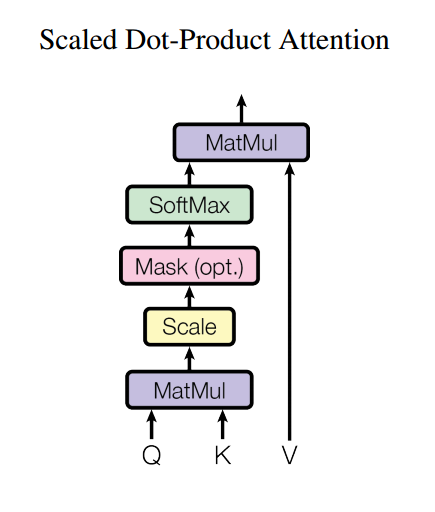

Scaled Dot-Product Attention(self-attention) 的公式长这个样子：
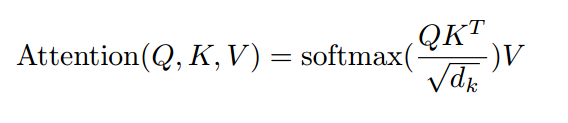

## BERT 的核心模块 transformer_model 开始了

In [8]:
#######################################此处一万个注意#######################################
#################由于BERT本身有很多层，比如large版本num_hidden_layers是24层#################
#################所以此处最开始是个for循环24次，我们下面只展示BERT的第一层#################
######################################呼应模型的开始########################################
all_layer_outputs = [] ## 把BERT每一层的都记录下来
##google 的TPU的Re-shapes具有计算成本，为了减少整个网络中的Re-shape操作所以把该tensor用2D表示
prev_output = tf.reshape(input_tensor, [-1, input_width])## 表示上一层的输入
get_shape_list(prev_output)

[4608, 1024]

In [9]:
## 把上一次的输出作为该层的输入
layer_input = prev_output
get_shape_list(layer_input)

[4608, 1024]

## 1. 我们开始part1： Multi-Head Attiontion 的操作

In [10]:
#线性变换生成Q,K,V
query_layer = tf.layers.dense(layer_input, attention_head_size*num_attention_heads, activation=None, kernel_initializer=create_initializer(0.02))
key_layer = tf.layers.dense(layer_input, attention_head_size*num_attention_heads, activation=None, kernel_initializer=create_initializer(0.02))
value_layer = tf.layers.dense(layer_input, attention_head_size*num_attention_heads, activation=None, kernel_initializer=create_initializer(0.02))
print("shape of query_layer: ", get_shape_list(query_layer))
print("shape of key_layer: ", get_shape_list(key_layer))
print("shape of value_layer: ", get_shape_list(value_layer))

Instructions for updating:
Use keras.layers.dense instead.
shape of query_layer:  [4608, 1024]
shape of key_layer:  [4608, 1024]
shape of value_layer:  [4608, 1024]


In [11]:
# Q,K 切分成多头
query_layer = to_multi_head(query_layer, batch_size, num_attention_heads, max_sequence_length, attention_head_size)
key_layer = to_multi_head(key_layer, batch_size, num_attention_heads, max_sequence_length, attention_head_size)
print("shape of query_layer: ", get_shape_list(query_layer))
print("shape of key_layer: ", get_shape_list(key_layer))

shape of query_layer:  [12, 16, 384, 64]
shape of key_layer:  [12, 16, 384, 64]


#### 开始Scaled Dot-Product Attention(self-attention) 操作

In [12]:
attention_scores = tf.matmul(query_layer, key_layer, transpose_b=True)
attention_scores = tf.multiply(attention_scores, 1.0 / math.sqrt(float(attention_head_size)))##参考公式scale 操作
get_shape_list(attention_scores)

[12, 16, 384, 384]

#### 使用attention_mask 对得到的attention_scores 中的原来pad位置的值进行删除操作

In [13]:
## 本质上把pad的位置0 转为-10000，然后送入softmax 就缩放为0了 
attention_mask = tf.expand_dims(attention_mask, axis=[1])
##因为attention_mask为1.0表示我们想要参加的位置，为0.0表示掩码位置，这个操作将创建一个张量为0.0 变为我们想参加的职位和-10000.0变为隐藏职位。
adder = (1.0 - tf.cast(attention_mask, tf.float32)) * -10000.0
## 因为我们是在softmax之前将其添加到原始分数中，这与完全删除这些分数是一样的。
attention_scores += adder
get_shape_list(attention_scores)

[12, 16, 384, 384]

In [14]:
## 将注意力分数归一化为概率。
attention_probs = tf.nn.softmax(attention_scores)## axis 为最后一维度，也就是[384,384] 该矩阵的行
get_shape_list(attention_probs)

[12, 16, 384, 384]

In [15]:
## attention 中的dropout  总共cycle num_hidden_layers 次
## this operation is taken from the original Transformer paper.
attention_probs = tf.nn.dropout(attention_probs, 1-bert_config["attention_probs_dropout_prob"]) ## attention 中的dropout
get_shape_list(attention_probs)

[12, 16, 384, 384]

In [16]:
# Scaled Dot-Product Attention(self-attention) 中最后一步的Matmul 操作
value_layer = tf.reshape(value_layer, [batch_size, max_sequence_length, num_attention_heads, attention_head_size])
value_layer = tf.transpose(value_layer, [0, 2, 1, 3])
context_layer = tf.matmul(attention_probs, value_layer)
get_shape_list(context_layer)

[12, 16, 384, 64]

In [17]:
## 对生成的context_layer 进行transpose， 然后又3D转为2D，与prev_output进行匹配
context_layer = tf.transpose(context_layer, [0, 2, 1, 3])
context_layer = tf.reshape(context_layer, [batch_size*max_sequence_length, num_attention_heads*attention_head_size])
get_shape_list(context_layer)

[4608, 1024]

很多人不明白transformer为什么要这样设计，假设我们的句子的序列长度是2即{token1,token2}， 我们会得到下面的图  
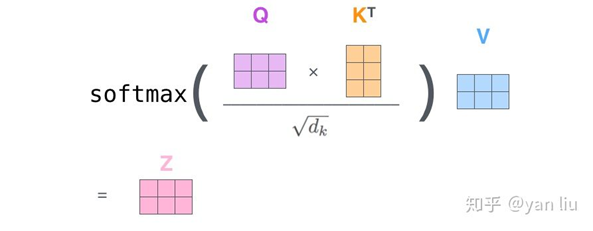
我们都知道softmax得到的是概率值，我们也可以看成t1与t2的权重值，我们得到的每个词向量对上下文每个词的都有一个量化的关注度，这就是Attention。     
最终生成的Z矩阵，假设每行看成t1与t2的词向量，经过上述attention的操作t1与t2就会自动产生某种联系。  
由于Q，K，V均是来自于input_tensor,所以我们又称它为self-attention 操作。    

如果把序列的长度扩大一些，假设为{token1, token2, ..., tokenk}  
下图中的单词it与上下文中每个词都有一定的关注度  
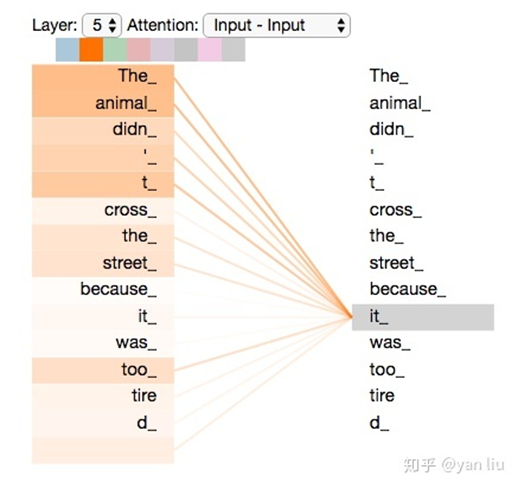  
经过这样的操作，能够感觉到词向量的表征增强了。

In [18]:
## 重新定义一个变量
attention_output = context_layer
get_shape_list(attention_output)

[4608, 1024]

In [19]:
## Multi-Head Attention 中的dropout + LN + shortcut 
attention_output = tf.layers.dense(attention_output, hidden_size, activation=None, kernel_initializer=create_initializer(0.02))
attention_output = tf.nn.dropout(attention_output, 1 - bert_config["hidden_dropout_prob"]) ## Multi-Head Attention 中的dropout
attention_output = tf.contrib.layers.layer_norm(attention_output + layer_input,
                                                begin_norm_axis=-1, begin_params_axis=-1) ##Multi-Head Attention FFN中的 LN+shortcut
get_shape_list(attention_output)                                                                

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



[4608, 1024]

#### part1： Multi-Head Attention 的操作到此结束

## 2. 我们开始part2： Feed Forward Network的操作  

先看下FFN的公式： 先升维度在降维 + shortcut 
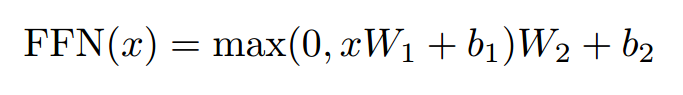

In [20]:
## step1 升维度 1024 -> 4096
intermediate_output = tf.layers.dense(
    attention_output,
    bert_config["intermediate_size"],
    activation=gelu,
    kernel_initializer=create_initializer(0.02))
get_shape_list(intermediate_output)

[4608, 4096]

In [21]:
## step2 再降维 4096 -> 1024
layer_output = tf.layers.dense(
    intermediate_output,
    hidden_size,
    kernel_initializer=create_initializer(0.02))
get_shape_list(layer_output)

[4608, 1024]

In [22]:
## FFN中的dropout + LN + shortcut 
layer_output = tf.nn.dropout(layer_output, 1 - bert_config["hidden_dropout_prob"])##FFN 中的dropout
layer_output = tf.contrib.layers.layer_norm(layer_output + attention_output,
                                           begin_norm_axis=-1, begin_params_axis=-1) ##FFN 中的LN + shortcut
get_shape_list(layer_output)

[4608, 1024]

In [23]:
########################################呼应模型的开始#######################################
## 还记得最开始的prev_output
prev_output = layer_output
all_layer_outputs.append(layer_output)
all_layer_outputs

[<tf.Tensor: id=316, shape=(4608, 1024), dtype=float32, numpy=
 array([[-0.6855281 ,  0.02223982,  0.97750175, ...,  1.3575083 ,
          0.1398837 ,  1.4403425 ],
        [-0.8997283 , -0.38768873, -0.27222434, ..., -1.4242222 ,
          0.26448172, -0.06245486],
        [-0.5097135 , -0.02311106, -1.6007283 , ...,  2.0647278 ,
          0.01808134,  0.063169  ],
        ...,
        [ 1.4806564 ,  0.66454995,  0.40720376, ..., -0.08296168,
         -0.37221035, -1.666284  ],
        [ 1.0267923 ,  0.64586794,  0.5321996 , ...,  0.7996957 ,
          1.6778431 ,  0.7657474 ],
        [-0.8738159 , -0.6283447 ,  1.035722  , ...,  1.6642292 ,
          1.7217278 , -1.3087621 ]], dtype=float32)>]